In [3]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # 日付データを扱うための補助ツール
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフにする）

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa  # 時系列解析用のモジュール

# 予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)
# これにより、DataFrameを print したときに
# 全角文字がきれいに整列して表示される

In [2]:
# -------------------------------------------------------
# 🎲 正規分布に従う乱数の生成
# -------------------------------------------------------

# ① 乱数の種を固定
#   - np.random.seed(1) により乱数の再現性を確保する。
#   - 同じ seed 値を指定すると、毎回同じ乱数系列が生成される。
np.random.seed(1)

# ② 正規分布（平均0, 標準偏差1）に従う乱数を生成
#   - loc   : 平均値（μ）= 0
#   - scale : 標準偏差（σ）= 1
#   - size  : 生成するサンプル数 = 4
#   - stats.norm.rvs() は SciPy の関数で、「連続確率分布から乱数を生成」するために用いられる。
from scipy import stats

stats.norm.rvs(loc=0, scale=1, size=4)

# ✅ 出力は例として以下のような形になる：
# array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862])
#
# これは平均0・標準偏差1の正規分布（ガウス分布）から得られた4つのサンプルである。

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862])

In [4]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
air_passengers.index = pd.date_range(
    start="1949-01-01", periods=len(air_passengers), freq="MS"
)

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [5]:
# 訓練データとテストデータに分割する
train = air_passengers.loc["1949-01":"1957-12"]
test = air_passengers.loc["1958-01":"1960-12"]

In [6]:
# -------------------------------------------------------
# 📈 ナイーブ予測（Naive Forecast）の実装
# -------------------------------------------------------

# 最後の観測値をテストデータ期間にそのまま繰り返す
naive_pred = pd.DataFrame(
    {
        "value": np.tile(
            train.loc["1957-12-01"], len(test)
        )  # 最後の訓練データを繰り返す
    },
    index=test.index,
)

# 結果の確認（最初の3行）
print(naive_pred.head(3))

# ✅ 解説：
# ・ナイーブ予測（Naive Forecast）は、最も単純な時系列予測モデルの一つである。
# ・「次の時点の値は、直前の観測値と同じになる」と仮定して予測を行う。
# ・この手法はトレンドや季節性を考慮しないため、基準モデル（ベースライン）として利用される。
# ・実際のモデル（ARIMA、SARIMAなど）の性能を比較する際に、
#   このナイーブ予測を「最低限の基準」として扱うことが多い。

            value
1958-01-01    336
1958-02-01    336
1958-03-01    336


In [7]:
# -------------------------------------------------------
# 📆 季節ナイーブ予測（Seasonal Naive Forecast）の実装
# -------------------------------------------------------

# 1957年の12か月分のデータを3年間分（＝36か月）繰り返す
s_naive_pred = pd.concat([train.loc["1957"]] * 3)

# テストデータと同じインデックスに置き換える
s_naive_pred.index = test.index

# 結果の確認（先頭3行）
print(s_naive_pred.head(3))

# ✅ 解説：
# ・このモデルは「季節ナイーブ予測（seasonal naive）」と呼ばれる。
# ・前年同月（または同季節）の値が今年も同じであると仮定して予測する。
# ・つまり、季節性を持つデータにおいて「1年前と同じ動きをする」とする単純なモデルである。
# ・ナイーブ予測よりも季節性を考慮しているため、月次・四半期データなどで基準モデルとして用いられる。

            value
1958-01-01    315
1958-02-01    301
1958-03-01    356


In [8]:
# -------------------------------------------------------
# 📊 平均値予測（Mean Forecast）の実装
# -------------------------------------------------------

# 訓練データの平均値を、テストデータ期間全体に繰り返し適用
mean_pred = pd.DataFrame(
    {
        "value": np.tile(
            train.mean(), len(test)
        )  # 平均値をテストデータと同じ件数だけ繰り返す
    },
    index=test.index,
)

# 結果の確認（先頭3行）
print(mean_pred.head(3))

# ✅ 解説：
# ・平均値予測（Mean Forecast）は、過去の観測データの平均値を将来の全ての時点にそのまま使う手法である。
# ・トレンド（増減）や季節性（周期的変動）を無視し、過去の全体的な水準を一定とみなす。
# ・「データに明確な傾向がない」場合の基準モデル（ベースライン）として使用される。
# ・他のモデル（例：ARIMA, SARIMA, Holt-Wintersなど）の性能比較時に
#   「単純な平均予測より改善しているか」を確認するための基準にもなる。

                 value
1958-01-01  230.898148
1958-02-01  230.898148
1958-03-01  230.898148


In [9]:
# -------------------------------------------------------
# 📈 過去1年間の平均値による予測（移動平均型予測）
# -------------------------------------------------------

# 過去1年間（1957年1月〜12月）の平均値を求め、
# その平均値をテストデータ期間の全ての予測値として使用する
ma_pred = pd.DataFrame(
    {
        "value": np.tile(
            train.loc["1957-1":"1957-12"].mean(), len(test)
        )  # 1957年の平均を繰り返す
    },
    index=test.index,
)

# 結果の確認（先頭3行）
print(ma_pred.head(3))

# ✅ 解説：
# ・この方法は「移動平均型予測（moving average forecast）」の一種であり、
#   最新の一定期間（ここでは直近1年）の平均値を将来の予測に用いる。
# ・直近のデータが現在のトレンドをよりよく反映しているという仮定に基づく。
# ・平均値予測（全期間平均）よりも短期的な変化に敏感であり、
#   データに緩やかなトレンドや季節性がある場合に有効なベースライン手法である。
# ・ただし、周期性が強い場合（例えば月次の季節変動）は、
#   単純平均よりも「季節調整済み」モデルを使う方が適切な場合もある。

                 value
1958-01-01  368.416667
1958-02-01  368.416667
1958-03-01  368.416667


In [10]:
# -------------------------------------------------------
# 📈 平均的なドリフト（平均変化量）の算出
# -------------------------------------------------------

# 1949年1月から1957年12月までのデータにおいて、
# 全期間の変化量を観測数 - 1 で割ることで、
# 各時点ごとの平均的な増加（または減少）量を求める。

drift = (train.loc["1957-12-01"] - train.loc["1949-01-01"]) / (len(train) - 1)
drift

# ✅ 解説：
# ・「ドリフト（drift）」とは、時系列データの平均的な傾向（トレンド）を表す値である。
# ・この式では、始点（1949年1月）から終点（1957年12月）までの
#   総変化量を観測期間の長さ（n−1）で割ることで、
#   1期間あたりの平均的な変化を算出している。
# ・結果は「1ヶ月あたりの平均増加量」を意味し、
#   ドリフト項を含むモデル（たとえばランダムウォーク＋ドリフト）で利用できる。
# ・この値を将来予測に加えることで、一定の上昇または下降トレンドを考慮できる。

value    2.093458
dtype: float64

In [11]:
# -------------------------------------------------------
# 📈 ドリフト項を用いた予測（ランダムウォーク＋ドリフトモデル）
# -------------------------------------------------------

# 「ドリフト（平均変化量）」を月ごとに累積し、
# それを最終観測値（1957年12月）の値に加算して将来の予測値を生成する。
drift_pred = pd.DataFrame(
    {"value": np.cumsum(np.tile(drift, len(test))) + train.loc["1957-12-01"].values},
    index=test.index,
)

# 結果の確認（先頭3行）
print(drift_pred.head(3))

# ✅ 解説：
# ・これは「ランダムウォーク＋ドリフト（Random Walk with Drift）」型の予測である。
# ・単純なナイーブ予測（最後の値をそのまま繰り返す）とは異なり、
#   平均的なトレンド（ドリフト）を考慮して将来値を増加（または減少）させている。
# ・ドリフト項は、過去全期間の平均的な変化量を反映しており、
#   緩やかな上昇・下降傾向を持つ時系列データに対して有効である。
# ・累積和（np.cumsum）によって、期間が進むごとにドリフトが積み上がり、
#   予測値が時間とともに線形的に増加することを意味する。

                 value
1958-01-01  338.093458
1958-02-01  340.186916
1958-03-01  342.280374


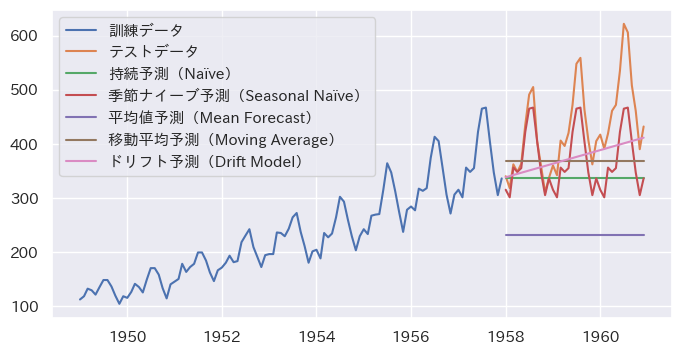

In [12]:
# -------------------------------------------------------
# 📊 予測モデルの可視化：複数手法の比較グラフ
# -------------------------------------------------------

# グラフサイズを指定して描画領域を作成
fig, ax = plt.subplots(figsize=(8, 4))

# 訓練データ（学習に使用した期間）の折れ線グラフ
ax.plot(train["value"], label="訓練データ")

# テストデータ（予測対象期間）の折れ線グラフ
ax.plot(test["value"], label="テストデータ")

# 各予測モデルの折れ線グラフを重ねて比較
ax.plot(naive_pred["value"], label="持続予測（Naïve）")
ax.plot(s_naive_pred["value"], label="季節ナイーブ予測（Seasonal Naïve）")
ax.plot(mean_pred["value"], label="平均値予測（Mean Forecast）")
ax.plot(ma_pred["value"], label="移動平均予測（Moving Average）")
ax.plot(drift_pred["value"], label="ドリフト予測（Drift Model）")

# 凡例（どの線がどのモデルに対応するか）を表示
ax.legend()

# ✅ 解説：
# ・このグラフは、時系列データの代表的な単純予測モデルを比較している。
# ・「持続予測」は直前の値をそのまま延長する最も単純なモデル。
# ・「季節ナイーブ」は1年前の同月の値を繰り返す（季節性を考慮）。
# ・「平均値予測」は過去の平均を一定値として出す。
# ・「移動平均予測」は直近の一定期間の平均を使う。
# ・「ドリフト予測」は線形トレンド（平均的な増減傾向）を考慮したモデル。
# → これらを重ねて比較することで、データの特性に最も合うモデルを視覚的に判断できる。

In [13]:
# -------------------------------------------------------
# 📈 平均絶対誤差（MAE: Mean Absolute Error）の算出
# -------------------------------------------------------

# テストデータ（実測値）と予測値（naive_pred）の誤差を計算
# np.abs() : 絶対値を取る（誤差の符号を無視）
# .mean()  : 平均を取ることで、全体の平均誤差を算出する
mae_naive = np.abs(test - naive_pred).mean()

# 結果の表示
mae_naive

value    94.944444
dtype: float64

In [14]:
# -------------------------------------------------------
# 📊 各モデルの平均絶対誤差（MAE: Mean Absolute Error）の比較
# -------------------------------------------------------

# sklearn.metrics.mean_absolute_error を用いて、
# 各予測モデルと実測値（test）との誤差を評価する
# MAEは誤差の平均的な大きさを示し、値が小さいほど精度が高い

print("持続予測　　：", mean_absolute_error(test, naive_pred))
print("季節ナイーブ：", mean_absolute_error(test, s_naive_pred))
print("平均値予測　：", mean_absolute_error(test, mean_pred))
print("移動平均予測：", mean_absolute_error(test, ma_pred))
print("ドリフト予測：", mean_absolute_error(test, drift_pred))

持続予測　　： 94.94444444444444
季節ナイーブ： 60.083333333333336
平均値予測　： 197.60185185185188
移動平均予測： 74.06018518518519
ドリフト予測： 62.84215991692627


In [15]:
# -------------------------------------------------------
# 📈 持続予測モデル（Naïve Forecast）の平均二乗誤差（MSE）の算出
# -------------------------------------------------------

# 「(予測値 - 実測値)^2」の平均を取ることで、誤差の二乗平均（MSE）を求める。
# 二乗することで大きな誤差をより強調して評価できる。

((test - naive_pred) ** 2).mean()

value    14674.555556
dtype: float64

In [16]:
# -------------------------------------------------------
# 🎯 各予測モデルの平均二乗誤差（MSE: Mean Squared Error）の比較
# -------------------------------------------------------

# MSE（Mean Squared Error）は、誤差（二乗誤差）の平均値であり、
# 予測の「精度（誤差の大きさ）」を数値的に評価する指標である。
# 値が小さいほど、予測の精度が高いことを意味する。

print(
    "持続予測　　：", mean_squared_error(test, naive_pred)
)  # 最終値をそのまま使う単純予測
print(
    "季節ナイーブ：", mean_squared_error(test, s_naive_pred)
)  # 1年前の同月を用いた季節性予測
print(
    "平均値予測　：", mean_squared_error(test, mean_pred)
)  # 全期間の平均値を予測値とする
print(
    "移動平均予測：", mean_squared_error(test, ma_pred)
)  # 直近1年間の平均を用いた予測
print(
    "ドリフト予測：", mean_squared_error(test, drift_pred)
)  # 一定の傾きを持つトレンド予測

持続予測　　： 14674.555555555555
季節ナイーブ： 5418.75
平均値予測　： 45164.797410836756
移動平均予測： 9728.312499999996
ドリフト予測： 7695.698285148635


In [17]:
# -------------------------------------------------------
# 🎯 RMSE（Root Mean Squared Error）の計算
# -------------------------------------------------------

# RMSEは「平均二乗誤差（MSE）」の平方根を取ったものであり、
# 元のデータと同じ単位で予測誤差の大きさを表す指標である。
# 値が小さいほど、予測モデルの精度が高いことを意味する。

rmse_naive = np.sqrt(((test - naive_pred) ** 2).mean())
print("持続予測のRMSE：", rmse_naive)

持続予測のRMSE： value    121.13858
dtype: float64


In [18]:
# -------------------------------------------------------
# 🎯 RMSE（Root Mean Squared Error：平方平均平方根誤差）の比較
# -------------------------------------------------------

# 各予測モデルについてRMSEを算出し、予測精度を比較する。
# RMSEは誤差の二乗平均の平方根であり、元データと同じ単位で
# 「平均的にどれくらい外れているか」を表す。
# 値が小さいほど予測精度が高いことを意味する。

print("持続予測　　：", np.sqrt(mean_squared_error(test, naive_pred)))
print("季節ナイーブ：", np.sqrt(mean_squared_error(test, s_naive_pred)))
print("平均値予測　：", np.sqrt(mean_squared_error(test, mean_pred)))
print("移動平均予測：", np.sqrt(mean_squared_error(test, ma_pred)))
print("ドリフト予測：", np.sqrt(mean_squared_error(test, drift_pred)))

# -------------------------------------------------------
# 💡 補足
# -------------------------------------------------------
# - 「持続予測（naive）」：直前の値をそのまま次の予測とする単純モデル。
# - 「季節ナイーブ予測」：1年前の同じ月の値を使う季節性を考慮した単純モデル。
# - 「平均値予測」：訓練データ全体の平均を予測値とする。
# - 「移動平均予測」：直近の一定期間の平均を用いる。
# - 「ドリフト予測」：トレンド（傾き）を考慮して直線的に予測する。
#
# RMSEは「大きな誤差を強く penalize（罰則）」する性質を持つため、
# 外れ値がある場合には値が大きくなりやすい。
# MAEと合わせて評価することで、モデルの安定性と精度を総合的に判断できる。

持続予測　　： 121.13857996342682
季節ナイーブ： 73.61215932167728
平均値予測　： 212.52011060329505
移動平均予測： 98.63220822834697
ドリフト予測： 87.7251291543571


In [19]:
# -------------------------------------------------------
# 🎯 MAPE（Mean Absolute Percentage Error：平均絶対パーセント誤差）
# -------------------------------------------------------

# MAPEは、予測値と実測値の誤差を「実測値に対する割合（％）」で表した指標。
# 平均的にどれくらいの割合で外れているかを示す。
# 値が小さいほど予測精度が高いことを意味する。

mape_naive = (np.abs(test - naive_pred) / test).mean()
print("持続予測のMAPE：", mape_naive)

# -------------------------------------------------------
# 💡 補足
# -------------------------------------------------------
# - MAPEは「直感的に理解しやすい」指標であり、誤差を％で解釈できる。
# - 例えば、MAPE = 0.08（= 8%）なら「平均的に8%の誤差がある」ことを意味する。
# - ただし、実測値 test が0に近い場合、誤差率が極端に大きくなるため注意が必要。
#   （0除算が発生する可能性がある）
# - そのような場合は「SMAPE（対称平均絶対パーセント誤差）」などを用いると良い。

持続予測のMAPE： value    0.198867
dtype: float64


In [20]:
# -------------------------------------------------------
# 🎯 MAPE（Mean Absolute Percentage Error：平均絶対パーセント誤差）の比較
# -------------------------------------------------------

# 各予測モデルについてMAPEを算出し、平均的な誤差率を評価する。
# MAPEは、予測値と実測値の絶対誤差を実測値で割り、
# それを平均したもの（誤差を割合で表す）。
# 値が小さいほど、予測精度が高いことを意味する。

print("持続予測　　：", mean_absolute_percentage_error(test, naive_pred))
print("季節ナイーブ：", mean_absolute_percentage_error(test, s_naive_pred))
print("平均値予測　：", mean_absolute_percentage_error(test, mean_pred))
print("移動平均予測：", mean_absolute_percentage_error(test, ma_pred))
print("ドリフト予測：", mean_absolute_percentage_error(test, drift_pred))

# -------------------------------------------------------
# 💡 補足
# -------------------------------------------------------
# - MAPEは「予測誤差を実測値の割合」で評価するため、
#   モデル間での比較やビジネス上の直感的理解に適している。
# - 例：MAPE = 0.12 → 平均で12%の誤差があるという意味。
#
# ⚠ 注意点
# - 実測値 test に0または0に近い値が含まれる場合、
#   分母が小さくなり誤差率が極端に大きくなる（または計算不能）。
# - そのような場合は **SMAPE（対称平均絶対パーセント誤差）** を用いると安定。
#
# ✅ MAPEはモデル評価の「相対的精度」を把握する上で有用な指標。

持続予測　　： 0.19886711926999853
季節ナイーブ： 0.13189432350948402
平均値予測　： 0.4441010032912314
移動平均予測： 0.15522265083435094
ドリフト予測： 0.12990464190138912


In [21]:
# -------------------------------------------------------
# 🎯 訓練データにおける「持続予測（Naive Forecast）」の1期先予測誤差
# -------------------------------------------------------

# 「持続予測（Naive Forecast）」とは：
#   → 前期の値をそのまま次期の予測値とする、最も単純な予測手法である。
#     例：ŷ_t = y_{t-1}
#
# 以下では、訓練データ（1949年〜1957年）において、
# 各月の値と「前月の値」の絶対誤差の平均（MAE）を計算している。
# これは、持続予測モデルの訓練期間内での平均誤差に相当する。

naive_error = np.abs(
    train["1949-02":"1957-12"].values - train["1949-01":"1957-11"].values
).mean()
print("訓練データにおける1期先持続予測の平均絶対誤差（MAE）：", naive_error)

# -------------------------------------------------------
# 💡 補足
# -------------------------------------------------------
# - この値は「1期先予測」での平均的なズレ（誤差）を表す。
# - 実際のテストデータでの誤差と比較することで、
#   モデルの汎化性能（未知データに対する予測力）を評価できる。
# - シンプルなベースライン（Naive法）は、
#   より高度なモデルの比較対象としてよく用いられる。

訓練データにおける1期先持続予測の平均絶対誤差（MAE）： 20.317757009345794


In [22]:
# -------------------------------------------------------
# 🎯 MASE（Mean Absolute Scaled Error：平均絶対スケーリング誤差）
# -------------------------------------------------------

# MASE は、予測誤差を「単純なナイーブ予測（1期前値）の誤差」でスケーリングした指標である。
# これにより、異なる系列間でも誤差を比較できるようになる。

# 数式：
#   MASE = mean( | y_t - ŷ_t | ) / mean( | y_t - y_{t-1} | )
#
# ・分子：テストデータにおける予測誤差の絶対値
# ・分母：訓練データにおけるナイーブ予測の平均絶対誤差（naive_error）

mase = (np.abs(test - naive_pred) / naive_error).mean()
print("MASE（平均絶対スケーリング誤差）：", mase)

# -------------------------------------------------------
# 💡 MASEの解釈
# -------------------------------------------------------
# - MASE < 1  → モデルはナイーブ予測よりも優れている（誤差が小さい）
# - MASE = 1  → モデルの精度はナイーブ予測と同等
# - MASE > 1  → モデルはナイーブ予測よりも劣っている（誤差が大きい）

# ✅ MASEの特徴
# - スケーリングによって系列のスケール依存性を除去できる。
# - 0除算の危険が少なく、MAPEよりも安定している。
# - 複数の時系列モデルを公平に比較する際に特に有用。

MASE（平均絶対スケーリング誤差）： value    4.672979
dtype: float64


In [23]:
# -------------------------------------------------------
# 🎯 各予測モデルの MASE（Mean Absolute Scaled Error：平均絶対スケーリング誤差）
# -------------------------------------------------------

# mean_absolute_scaled_error() は、scikit-learn 1.1以降で利用可能な関数であり、
# 予測誤差を「訓練データにおける1期先ナイーブ予測誤差」でスケーリングして評価する。
#
# 計算式：
#     MASE = mean( | y_t - ŷ_t | ) / mean( | y_t - y_{t-1} | )
#
# y_train を指定することで、分母（スケーリング基準）を訓練データに設定している。
# これにより、異なる予測モデルを公平に比較できる。

print("持続予測　　：", mean_absolute_scaled_error(test, naive_pred, y_train=train))
print("季節ナイーブ：", mean_absolute_scaled_error(test, s_naive_pred, y_train=train))
print("平均値予測　：", mean_absolute_scaled_error(test, mean_pred, y_train=train))
print("移動平均予測：", mean_absolute_scaled_error(test, ma_pred, y_train=train))
print("ドリフト予測：", mean_absolute_scaled_error(test, drift_pred, y_train=train))

# -------------------------------------------------------
# 💡 MASE の解釈
# -------------------------------------------------------
# ・MASE < 1：モデルがナイーブ予測より優れている（誤差が小さい）
# ・MASE = 1：ナイーブ予測と同等の精度
# ・MASE > 1：ナイーブ予測より劣るモデル
#
# MASEはMAPEと違ってゼロ除算が起きにくく、外れ値にも比較的頑健であるため、
# 時系列予測モデルの汎用的な性能比較指標として広く用いられる。

持続予測　　： 4.672978636410099
季節ナイーブ： 2.9571833793314934
平均値予測　： 9.725574125183142
移動平均予測： 3.645096510954377
ドリフト予測： 3.0929673924154146
